<h1 align='center'>Computing Wake Functions from FBPIC Simulations</h1>
<center>
Stephen D. Webb <br>
RadiaSoft, LLC <br>
swebb@radiasoft.net</center>

Developed for a project supported by the United States Department of Energy, Office of Science, Office of High Energy Physics under contract number DE-SC0018718.

## Usage

This iPython notebook is meant to be used to process data generated from simulations in local subdirectories. Those subdirectories contain benchmarking simulations for fbpic, as well as simulations of blowout plasma wakefield accelerators with nominally FACET-II-type parameters.

In [1]:
## Imports

# standard python libraries
import numpy as np
from scipy import constants
from scipy.special import erfc, k0, k1, kn

import shutil, os

%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py as hdf5

# OpenPMD for looking at the file data
from opmd_viewer import OpenPMDTimeSeries

# set the colormap and centre the colorbar

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

## Reading in the Data

In [2]:
## Metadata
n_plasma = 5.e16        # cm^-3

# convert to per cubic meter
n_plasma *= 100**3

# derived plasma quantities
omega_p = np.sqrt(n_plasma*constants.elementary_charge**2/(constants.m_e*constants.epsilon_0))
k_p = omega_p/constants.c

dir_name = './benchmarks/facet_blowout/facet_nowitness/hdf5'
step_num = 2200

In [3]:
ts = OpenPMDTimeSeries(dir_name)
Ez_field, meta = ts.get_field(field='E', coord='z', iteration=step_num)
Er_field, meta = ts.get_field(field='E', coord='r', iteration=step_num)
Bt_field, meta = ts.get_field(field='B', coord='t', iteration=step_num)
Jz_field, meta = ts.get_field(field='J', coord='z', iteration=step_num)

zs, xs, uz = ts.get_particle(var_list=['z', 'x', 'uz'], species='electrons', iteration=step_num)
zp, up, xp, yp = ts.get_particle(var_list=['z', 'uz', 'x', 'y'], species='plasma_electrons', iteration=step_num)

rgrid = meta.r
zgrid = meta.z

nr = meta.r.shape[0]
nz = meta.z.shape[0]

z0 = np.average(zs)*1.e-6

plt_extent=[(zgrid[0]-z0)*1.e6, (zgrid[-1]-z0)*1.e6, rgrid[0]*1.e6, rgrid[-1]*1.e6]
plt_extent_normed=[(k_p*(zgrid[0]-z0)),(k_p*(zgrid[-1]-z0)), rgrid[0]*1.e6, rgrid[-1]*1.e6]
aspect_ratio = np.abs(rgrid[0]/zgrid[0])/1.6

<IPython.core.display.Javascript object>


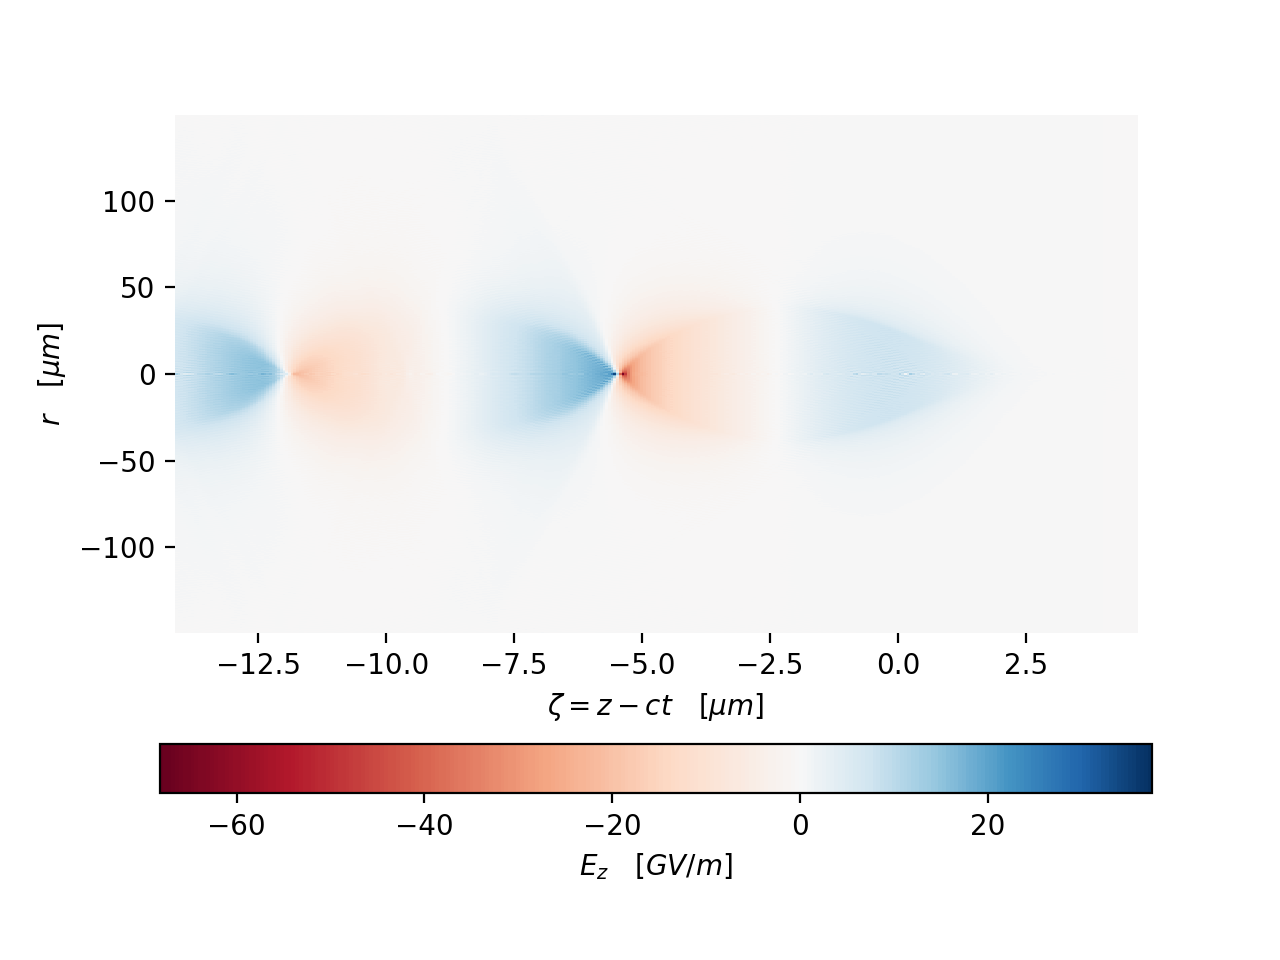

In [5]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

# Fix the midpoint to zero field

ezmax = np.amax(Ez_field*1.e-9)
ezmin = np.amin(Ez_field*1.e-9)
ezavg = 0.

plt.imshow(Ez_field*1.e-9, extent=plt_extent_normed,
           cmap='RdBu', origin='lower', aspect=aspect_ratio,
           norm=MidpointNormalize(midpoint=ezavg,vmin=ezmin, vmax=ezmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_z \quad [GV/m]$')

plt.savefig('Ez.png')

In [6]:
def compute_analytic_Ez(kp, sigma_z, Q, zeta):
        
    phase_arg = kp * zeta
    erfc_arg  = (zeta - 1.j*kp*sigma_z*sigma_z)/(np.sqrt(2)*sigma_z)
        
    Ez = np.exp(-1.j*phase_arg)*(erfc(erfc_arg))
    Ez = np.real(Ez)
    Ez *= Q * np.exp(- 0.5 * (kp * sigma_z)**2)/(2*np.pi*constants.epsilon_0)*k_p**2
    
    return Ez

<IPython.core.display.Javascript object>


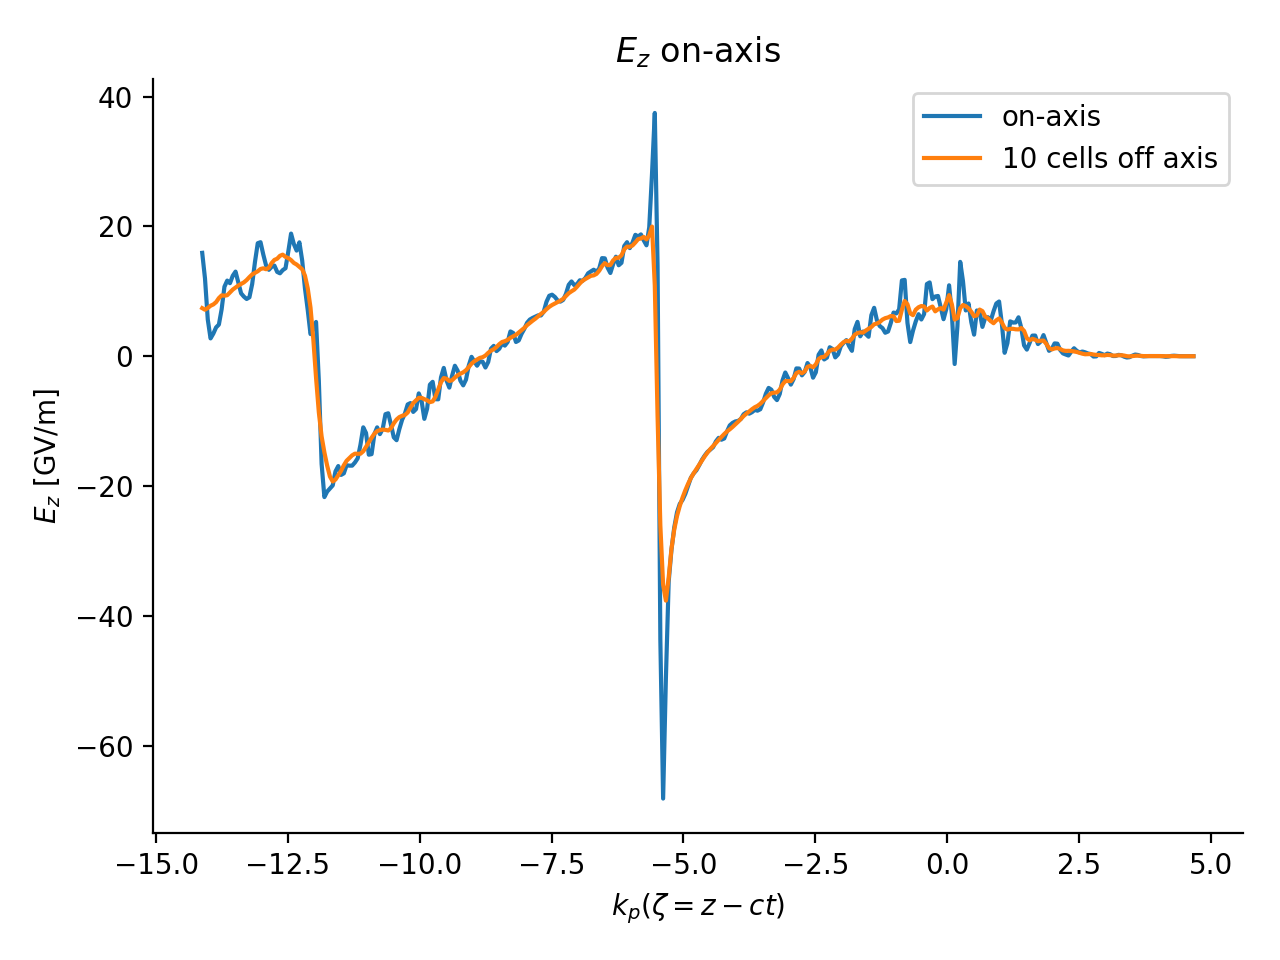

In [7]:
fig, ax = plt.subplots()

#Ez = compute_analytic_Ez(k_p, drive_sigma_z, drive_Q, (zgrid-z0))

ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

axis_idx = np.shape(Ez_field)[0]
plt.plot(k_p*(zgrid-z0),Ez_field[axis_idx/2,:]*1.e-9, label='on-axis')
plt.plot(k_p*(zgrid-z0),Ez_field[axis_idx/2+10,:]*1.e-9, label='10 cells off axis')
#plt.plot(k_p*(zgrid-z0),Ez*1.e-9, label='lin. theory')
plt.xlabel(r'$k_p (\zeta = z - ct)$')
plt.ylabel(r'$E_z$ [GV/m]')
plt.legend()
plt.title('$E_z$ on-axis')
plt.tight_layout()

plt.savefig('Ez_on_axis.png')

<IPython.core.display.Javascript object>


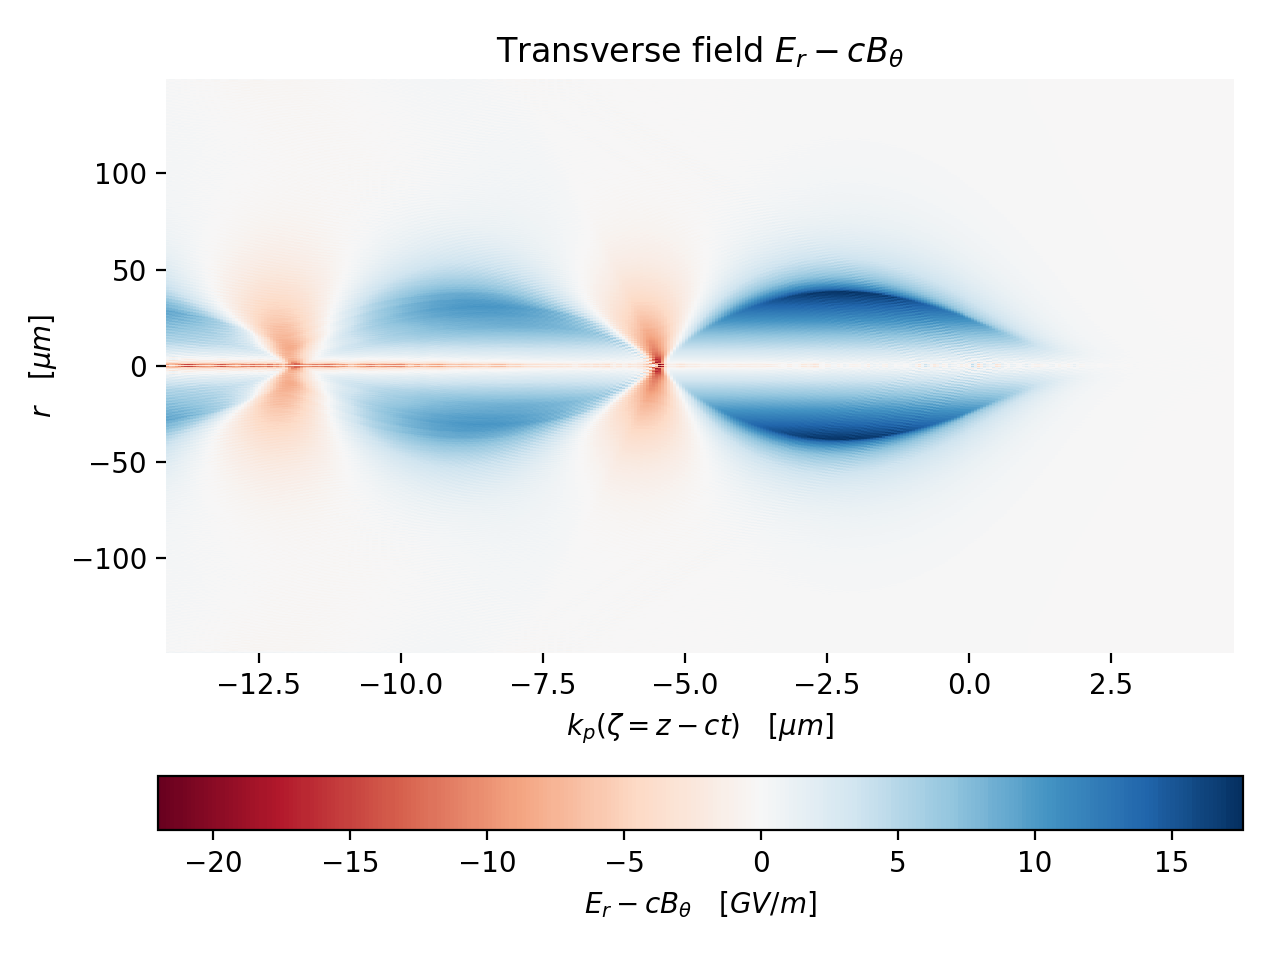

In [8]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
Fr = (Er_field - constants.speed_of_light*(Bt_field))*1.e-9

frmax = np.amax(Fr)
frmin = np.amin(Fr)
fravg = 0.

plt.imshow(Fr, extent=plt_extent_normed,
           cmap='RdBu', origin='lower', aspect=aspect_ratio,
           norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax))
plt.xlabel(r'$k_p (\zeta = z - c t) \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')
plt.title(r'Transverse field $E_r - c B_\theta$')
plt.tight_layout()

plt.savefig('transverse_field.png')

<IPython.core.display.Javascript object>


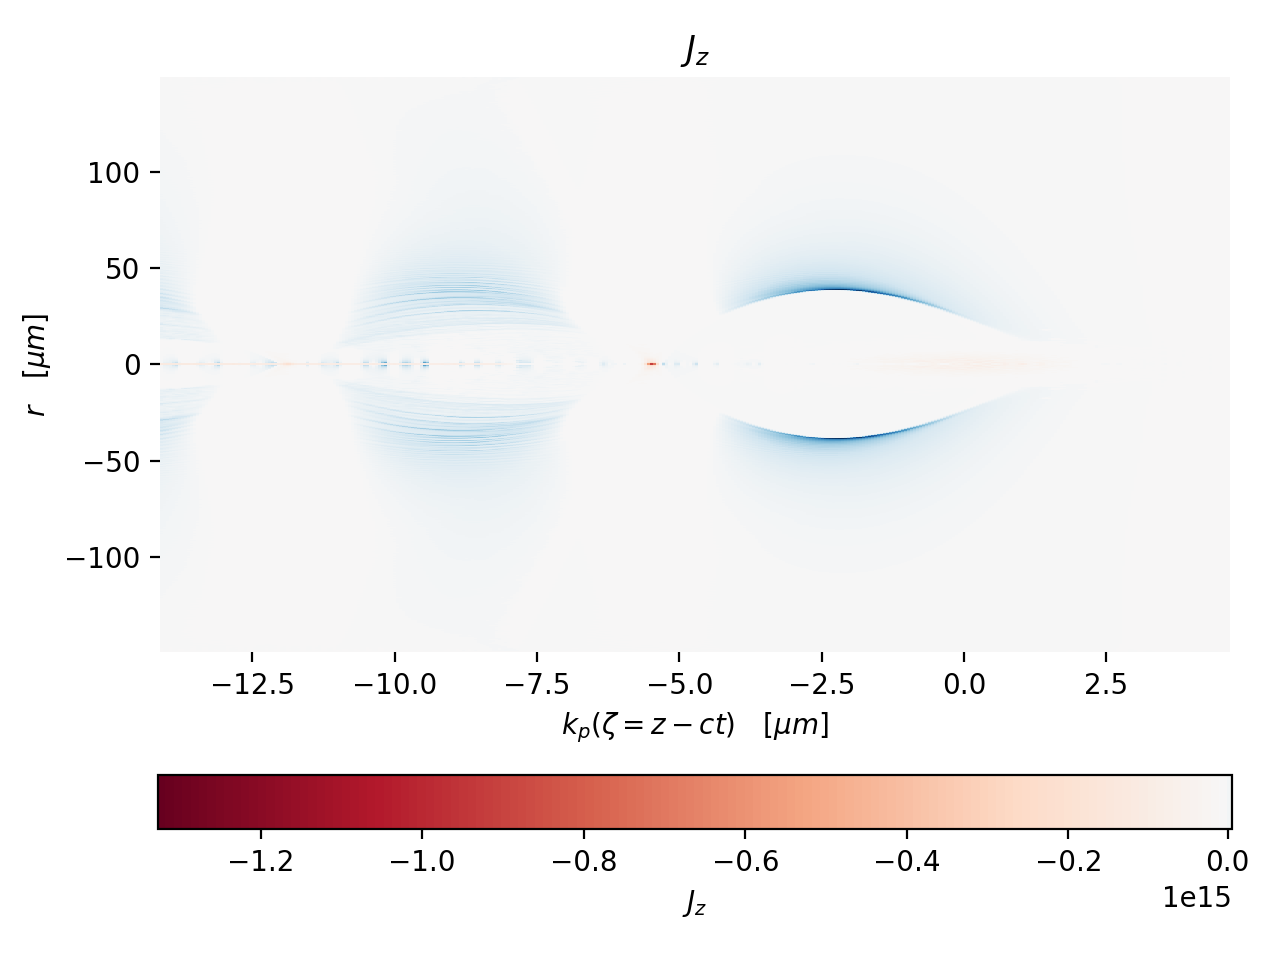

In [9]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
Fr = (Er_field - constants.speed_of_light*(Bt_field))*1.e-9

frmax = np.amax(Jz_field)
frmin = np.amin(Jz_field)
fravg = 0.

plt.imshow(Jz_field, extent=plt_extent_normed,
           cmap='RdBu', origin='lower', aspect=aspect_ratio,
           norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax))
plt.xlabel(r'$k_p (\zeta = z - c t) \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$J_z$')
plt.title(r'$J_z$')
plt.tight_layout()

plt.savefig('Jz.png')

<IPython.core.display.Javascript object>


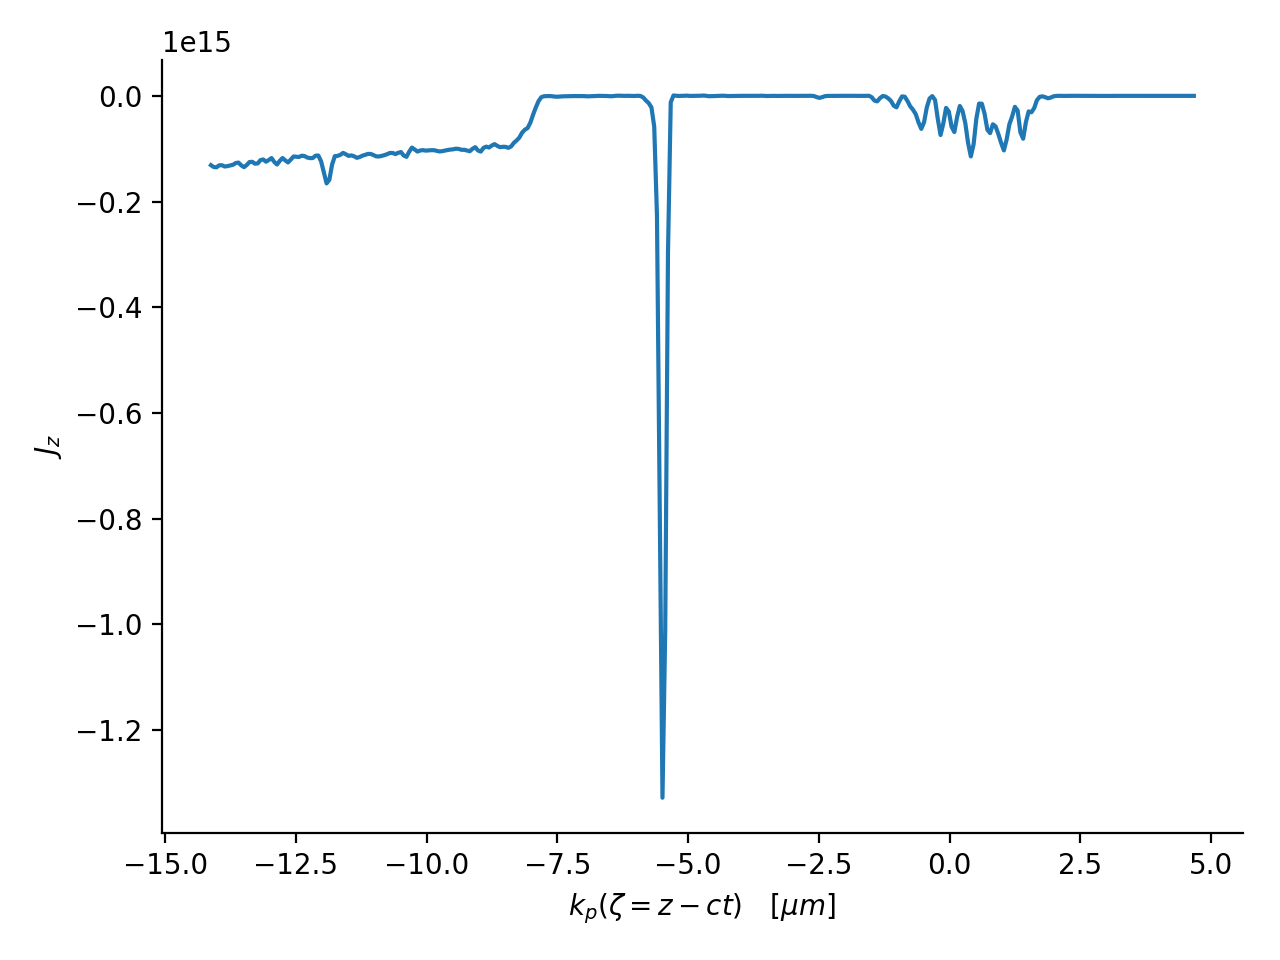

In [10]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
Fr = (Er_field - constants.speed_of_light*(Bt_field))*1.e-9

frmax = np.amax(Jz_field)
frmin = np.amin(Jz_field)
fravg = 0.

plt.plot(k_p*(zgrid-z0),Jz_field[axis_idx/2,:])
plt.xlabel(r'$k_p (\zeta = z - c t) \quad [\mu m]$')
plt.ylabel(r'$J_z$')
plt.tight_layout()

plt.savefig('Jz_lineout.png')

<IPython.core.display.Javascript object>


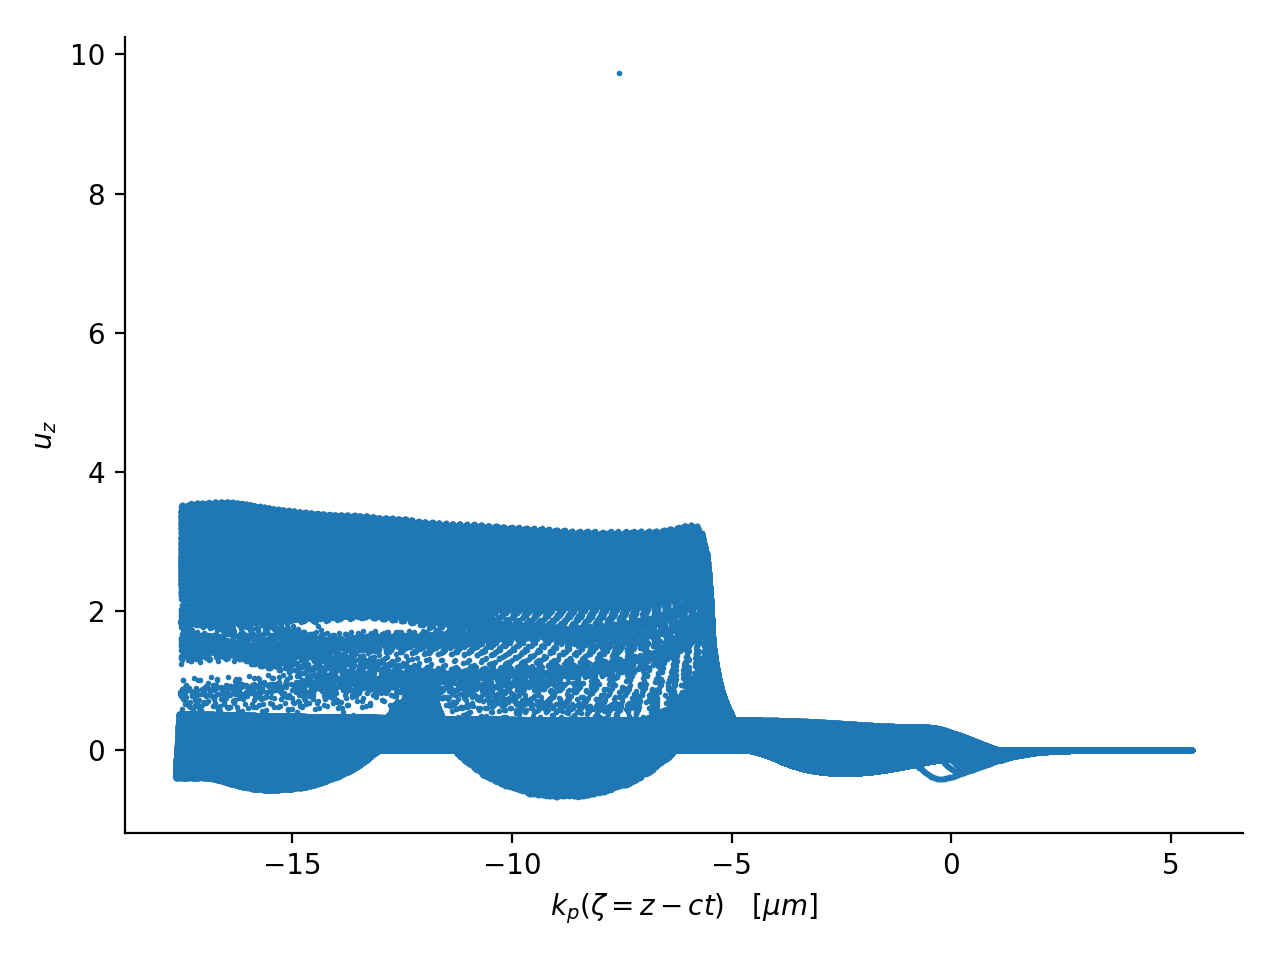

In [11]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
Fr = (Er_field - constants.speed_of_light*(Bt_field))*1.e-9

frmax = np.amax(Jz_field)
frmin = np.amin(Jz_field)
fravg = 0.

plt.scatter(k_p*(zp*1.e-6-z0),up, s=1.)
plt.xlabel(r'$k_p (\zeta = z - c t) \quad [\mu m]$')
plt.ylabel(r'$u_z$')
plt.tight_layout()

plt.savefig('z_scatter.png')

<IPython.core.display.Javascript object>


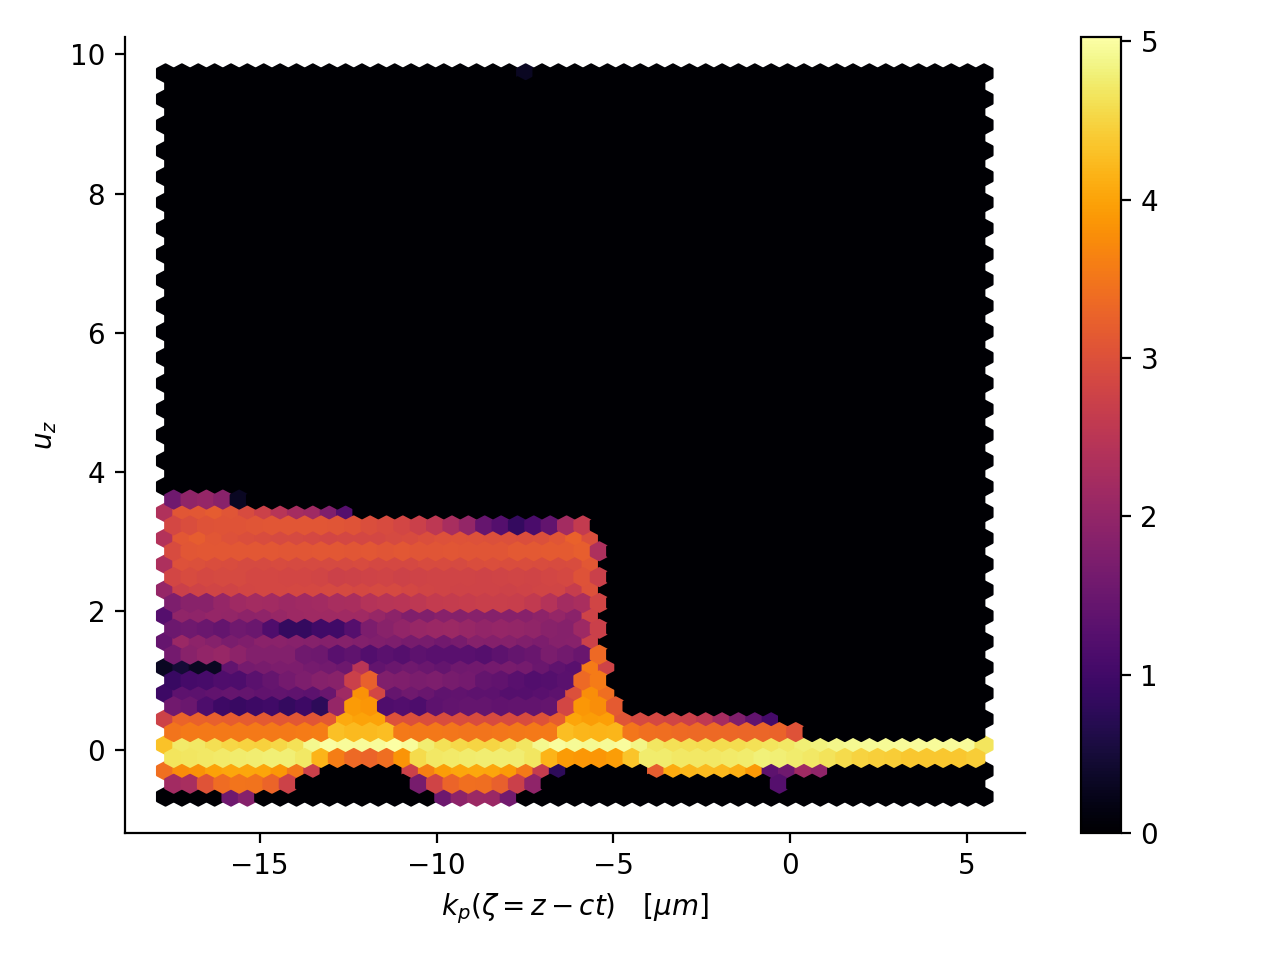

In [12]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

ax = plt.hexbin(k_p*(zp*1.e-6-z0),up,gridsize=50, bins='log', cmap='inferno')
plt.xlabel(r'$k_p (\zeta = z - c t) \quad [\mu m]$')
plt.ylabel(r'$u_z$')
plt.colorbar()
plt.tight_layout()

plt.savefig('z_phasespace.png')